In [58]:
%load_ext autoreload
%autoreload 1

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import numpy as np
%aimport tensorflow
import tensorflow as tf

import edward as ed
from edward.models import Normal, Bernoulli, Categorical
# from tensorflow.contrib.distributions import Categorical

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

print(ed.__version__)
print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.1.2
1.0.0


In [2]:
iris = load_iris()
X = iris.data[:, :2].astype(np.float32)
Y = iris.target.astype(np.int32)
C = len(iris.target_names)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [10]:
class BinaryModel(object):
    def __init__(self, N, D):
        self.X = tf.placeholder(tf.float32, shape=[N, D])
        self.w = Normal(mu=tf.zeros([D]), sigma=tf.ones([D]))
        self.b = Normal(mu=tf.zeros([1]), sigma=tf.ones([1]))
        self.s = Normal(mu=ed.dot(self.X, self.w) + self.b, sigma=tf.ones(N))
        self.qw = Normal(mu=tf.Variable(tf.random_normal([D])), sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        self.qb = Normal(mu=tf.Variable(tf.random_normal([1])), sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
        self.y = Bernoulli(logits=self.s)

    def fit(self, X, y):
        y = (y > 0).astype(np.int32)
        # inference = ed.MFVI({self.w: self.qw, self.b: self.qb}, data={self.X: X, self.y: y})
        # inference.run()
        inference = ed.Inference({self.w: self.qw, self.b: self.qb}, data={self.X: X, self.y: y})
        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()
        
    def predict_proba(self, X, y=None):
        y_post = ed.copy(self.y, {self.X: X, self.w: self.qw, self.b: self.qb})
        sess = ed.get_session()
        y_hat = sess.run(y_post.mean())
        return y_hat

In [57]:
model = BinaryModel(*X_train.shape)
model.fit(X_train, Y_train)
model.predict_proba(X_test)

array([  5.82982844e-04,   3.83698428e-03,   5.64901298e-03,
         2.89702602e-03,   3.82500514e-03,   1.85881509e-03,
         5.95472578e-04,   1.89975109e-02,   1.63579807e-02,
         2.39507407e-02,   4.53087091e-02,   4.32373350e-03,
         9.07501113e-03,   6.99760672e-03,   1.39794650e-03,
         1.24007941e-03,   1.56162726e-03,   3.78996687e-04,
         1.39530760e-03,   5.75790706e-04,   5.66998078e-03,
         8.84821755e-04,   1.64044928e-03,   4.69403400e-04,
         2.98791099e-04,   1.19498959e-02,   7.42657576e-04,
         6.57544378e-03,   5.59139624e-03,   1.61973678e-03,
         2.72609969e-03,   2.59756949e-03,   1.22905697e-03,
         1.33835971e-02,   1.59463802e-04,   8.38618074e-03,
         6.97880844e-03,   1.59374147e-03,   2.97951954e-03,
         1.22631118e-02,   1.34459755e-04,   6.52364906e-05,
         5.17150213e-04,   7.69510749e-04,   6.89820386e-03,
         3.71592119e-03,   1.36271864e-02,   2.25982582e-03,
         7.75552064e-04,

In [60]:
class MulticlassModel(object):
    def __init__(self, N, D, C):
        self.X = tf.placeholder(tf.float32, shape=[N, D])
        self.w = Normal(mu=tf.zeros([D, C]), sigma=tf.ones([D, C]))
        self.b = Normal(mu=tf.zeros([C]), sigma=tf.ones([C]))
        self.s = Normal(mu=tf.matmul(self.X, self.w) + self.b, sigma=tf.ones([N, C]))
        self.qw = Normal(mu=tf.Variable(tf.random_normal([D, C])), sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, C]))))
        self.qb = Normal(mu=tf.Variable(tf.random_normal([C])), sigma=tf.nn.softplus(tf.Variable(tf.random_normal([C]))))
        self.y = Categorical(logits=tf.nn.softmax(logits=self.s))

    def fit(self, X, y):
        # inference = ed.MFVI({self.w: self.qw, self.b: self.qb}, data={self.X: X, self.y: y})
        # inference.run()
        inference = ed.Inference({self.w: self.qw, self.b: self.qb}, data={self.X: X, self.y: y})
        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()
        
    def predict_proba(self, X, y=None):
        y_post = ed.copy(self.y, {self.X: X, self.w: self.qw, self.b: self.qb})
        sess = ed.get_session()
        y_hat = sess.run(y_post.probs)
        print(y_hat)
        return y_hat

In [65]:
c = Categorical(logits=[0.5, 0.5])
import inspect
print(inspect.getmembers(c))

Y_train = Y_train.astype(np.float32)
model = MulticlassModel(X_train.shape[0], X_train.shape[1], C)
model.fit(X_train, Y_train)
model.predict_proba(X_test)

[('__class__', <class 'edward.models.random_variables.Categorical'>), ('__delattr__', <method-wrapper '__delattr__' of Categorical object at 0x127130950>), ('__dict__', {'_value': <tf.Tensor 'RandomVariable_138/Categorical/sample/Reshape_2:0' shape=() dtype=int32>, '_name': 'RandomVariable_138/', '_dist_args': {'logits': [0.5, 0.5]}, '_dist': <tensorflow.contrib.distributions.python.ops.categorical.Categorical object at 0x12720d990>, '_dist_cls': <class 'tensorflow.contrib.distributions.python.ops.categorical.Categorical'>}), ('__doc__', None), ('__format__', <built-in method __format__ of Categorical object at 0x127130950>), ('__getattribute__', <method-wrapper '__getattribute__' of Categorical object at 0x127130950>), ('__hash__', <method-wrapper '__hash__' of Categorical object at 0x127130950>), ('__init__', <bound method Categorical.__init__ of <edward.models.random_variables.Categorical object at 0x127130950>>), ('__module__', 'edward.models.random_variables'), ('__new__', <built-

AttributeError: 'Categorical' object has no attribute '_name'

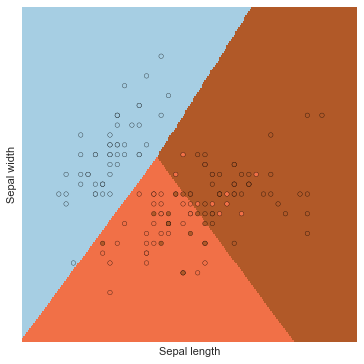

In [40]:
logreg = LogisticRegression(C=1e5)

# we create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, Y)

h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 6), facecolor='w')
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()